#Interetación de clasificación de imágenes con LIME. 

En este ejemplo se aúnan varias técnicas, incluida transferencia de aprendizaje sobre una red Inception.

## Librerías

In [1]:
import numpy as np
import scipy as sp

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from tensorflow.keras import layers, applications
from tensorflow.keras import Model

In [3]:
import skimage.io 
import skimage.segmentation
import copy

import sklearn
import sklearn.metrics
from keras.applications.imagenet_utils import decode_predictions
from sklearn.linear_model import LinearRegression

## Explorando los datos
Se descargan los datos en un fichero zip con 2000 imágenes de perros y gatos. Se descarga el zip y se extraen el directorio /tmp de la máquina virtual local. Estos datos son un subconjunto de 
["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) disponible en Kaggle.

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-08-29 11:13:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   130MB/s    in 0.5s    

2021-08-29 11:13:50 (130 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [5]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Los contenidos del zip son extraídos en el directorio `/tmp/cats_and_dogs_filtered`, conteniendo los directorios `train` and `validation`, los cuales a su vez contienen los subdirectorios `train` and `validation`.

In [6]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Visualizando los nombres de las imágenes en los diferentes directorios.

In [7]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.245.jpg', 'cat.572.jpg', 'cat.109.jpg', 'cat.862.jpg', 'cat.56.jpg', 'cat.491.jpg', 'cat.141.jpg', 'cat.298.jpg', 'cat.436.jpg', 'cat.565.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Número total de imágenes en cada categoría y directorio.



In [8]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


Para gatos y perro hay 1000 imágenes en el entrenamiento y 500 en la validación (test).

## Creación de un modelo Inception V3

Las imágenes color se escalan a tamaño image_size X image_size píxeles, aunque en realidad son objetos 150x150x3 debido a los 3 colores RGB.


In [9]:
#Se configura el tamaño de las imágenes.
image_size=128

In [10]:
# Se carga la parte convolucional del modelo entrenado VGG16.
# Very Deep Convolutional Networks for Large-Scale Image Recognition
# Karen Simonyan, Andrew Zisserman
# https://arxiv.org/abs/1409.1556

conv_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3) )

87924736/87910968 [==============================] - 4s 0us/step


In [11]:
conv_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
# Se añaden una capa flatten,
x = layers.Flatten()(conv_model.output)
# varias capas densas 
# (a medida que se añadan más capas densas el tiempo de entrenamiento se incrementa)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dense(100, activation='relu')(x)
#x = layers.Dense(100, activation='relu')(x)
# y una capa final softmax 
predictions = layers.Dense(2, activation='softmax', name='dense_output')(x)
# puesto que nuestro problema es un clasificador binario (gatos-perros)
# la capa de salida debe tener dos neuronas con softmax como función de activación.

In [13]:
# Crear el modelo completo
full_model = Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
# Bloquear el entrenamiento de todas las capas de la parte convolucional
for layer in conv_model.layers:
    layer.trainable = False

In [15]:
# Imprimir el número total de parámetros del modelo completo, 
# separando los entrenables de los no entrenables.
from keras.utils.layer_utils import count_params
trainable_count = count_params(full_model.trainable_weights) 
non_trainable_count = count_params(full_model.non_trainable_weights) 
  
print('Parámetros totales: {:,}'.format(trainable_count + non_trainable_count)) 
print('Parámetros entrenables: {:,}'.format(trainable_count)) 

Parámetros totales: 22,327,266
Parámetros entrenables: 524,482


In [16]:
# Se comprueba la estructura del modelo completo
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
# Entrenar el modelo.
from tensorflow.keras.optimizers import RMSprop

full_model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Se reescala la intensidad de las imágenes en un factor 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flujo de imágenes de entramiento en grupos de 32 
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(image_size, image_size),  
        batch_size=32,
        shuffle=True,
        class_mode='categorical')

# Flujo de imágenes de validación o test en grupo de 32 
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Entrenamiento

In [19]:
history=full_model.fit(
    train_generator, 
    epochs=3, 
    batch_size=32, 
    validation_data=validation_generator, verbose=1)

Epoch 1/3
63/63 [==============================] - 95s 1s/step - loss: 1.4675 - acc: 0.8525 - val_loss: 0.2977 - val_acc: 0.9160
Epoch 2/3
63/63 [==============================] - 88s 1s/step - loss: 0.3802 - acc: 0.9015 - val_loss: 0.3393 - val_acc: 0.8930
Epoch 3/3
63/63 [==============================] - 90s 1s/step - loss: 0.2427 - acc: 0.9320 - val_loss: 0.2362 - val_acc: 0.9130


## Tratamiento de la nueva imagen

### Leer y preprocesar la imagen.
Una nueva imagen con un perro y un gato en la misma es leída, reescalada y preprocesada por la red Inception V3.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

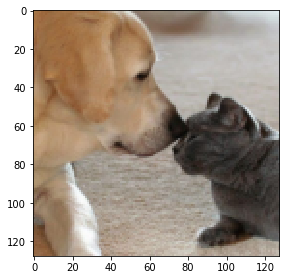

In [22]:
Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
Xi = skimage.transform.resize(Xi, (image_size,image_size)) # Reescalar
Xi = (Xi - 0.5)*2 # Preprocesar
skimage.io.imshow(Xi/2+0.5) # Mostrar imagen


# Descomentar para descargar
from google.colab import files
plt.savefig('img_catdog_original.eps')
files.download('img_catdog_original.eps')

In [ ]:
#Se genera el vector de predicción de 
pred_newimage = full_model.predict(Xi[np.newaxis,:,:,:])
print(pred_newimage)

[[5.76377e-28 1.00000e+00]]


In [ ]:
# Los índice de las clases son guaradados en la nueva variable. Se selecciona la clase más probable de la predicción. 
top_pred_classes = pred_newimage[0].argsort()[-2:][::-1]
top_pred_classes  

array([1, 0])

### Paso 1: Crear perturbaciones de las porciones de la imagen
Para explicar la clasificación de la imagen, se generan perturbaciones de las porciones que la forman mediante el apagado y encendido de sus superpíxeles.

Para ello se generan primero los superpíxeles mediante un algoritmo de segmentación. En este caso el algoritmo elegido es quickshift. Los parámetros del algoritmo permiten generar más o menos superpíxeles.

In [ ]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=10,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

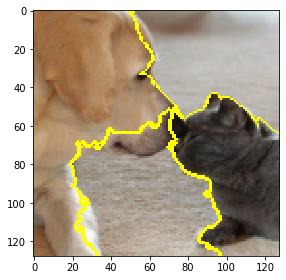

In [ ]:
img_catdog_segmented= skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

# Descomentar para descargar
from google.colab import files
plt.savefig('img_catdog_segmented_sp_'+str(num_superpixels)+'.eps')
files.download('img_catdog_segmented_sp_'+str(num_superpixels)+'.eps')

El siquiente paso es crear perturbaciones de los superpíxeles. La creación de un número más elevado de perturbaciones producirá explicaciones más confiables. 

Se crean máscaras que enciendan y apagen superpíxeles, y así crear imágenes con trozos aleatorizados.

In [ ]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 1, 1, 0])

La siguiente función perturba una image basándose en el vector de perturbación y los superpíxeles ambos generados anteriormente.

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img) 
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

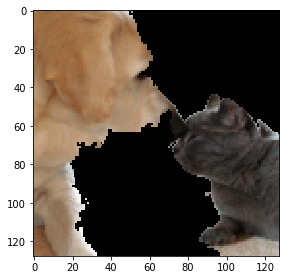

In [ ]:
# Visualización de una imagen ejemplo
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

### Paso 2: Usar un clasificador de ML para pronosticar las clase de las nuevas imágenes.

Con la imagen original (Xi), los superpíxeles y cada una de las máscaras (pert), se generan las imágenes perturbadas (con ciertos superpíxeles encendido y apagados); y finalmente se pronostica su clase con la red Inception. Así se construye un vector de predicciones (predictions).

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = full_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 2)

### Paso 3: Se calculan las distancias entre la imagen original y cada una de las imágenes perturbada, y además de calculan los pesos de cada imagen perturbada.  
Se calcula la distancia entre la imagen original (vector de dimensionalidad igual al número de superpíxeles y compuesto de unos) y cada una de las imágenes perturbadas (vector de igual dimensionalidad y compuesto de ceros y unos). Para la distancia se utiliza la métrica coseno.

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

#### Se usa una función kernel para calcular los pesos
Las distancias son mapeadas en valores en rando de cero a uno usando una función kernel. Se hace esto para que independientemente de la métrica de distancia utilizada, todos los pesos estén en este rango. Además distancias más pequeñas, imágenes perturbadas más cercanas a la imagen original, tendrán un peso mayor.

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

### Paso 4: Usar las perturbaciones, las predicciones y los pesos para ajustar un modelo lineal.

La elección del uso de un modelo lineal debe a su fácil explicabilidad.

El modelo lineal tiene como variable de entrada las coordenadas de la imagen perturbada (perturbations), como salida su predicción (predictions), y cada instancia está ponderado por un peso (weights). La acción del peso es dar más importancia a las imágenes cuya distancia a la imagen original es menor. 

Los coeficientes de la regresión lineal corresponden con cada uno de los superpíxeles de la imagen segmentada. Estos coeficientes representan como es de importante cada superpíxel para la predicción. Del signo del coeficiente puede extraerse si el superpíxel contribuye positivamente a la clasificiación bajo la clase seleccionada o no.

In [ ]:
class_to_explain = top_pred_classes[0] # [0] perro, [1] gato
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([-0.0210168 ,  0.45917629, -0.26848019, -0.26094392])

Se ordenan los coeficientes para ir activándolos progresivamente sobre la imagen segmentada.

In [ ]:
num_top_features = 1
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([1])

Se muestra una imagen con el número de superpíxeles seleccionado (num_top_feature) que son más explicativos de la clase de la imagen.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

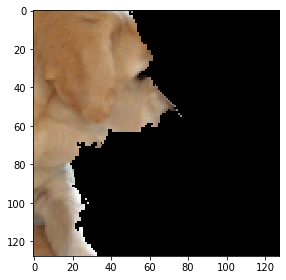

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

# Descomentar para descargar
from google.colab import files
plt.savefig('img_catdog_segmented_sp_'+str(num_superpixels)+'_best_sp_'+str(num_top_features)+'.eps')
files.download('img_catdog_segmented_sp_'+str(num_superpixels)+'_best_sp_'+str(num_top_features)+'.eps')